In [ ]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, GlobalMaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
import os
import numpy as np
import pandas as pd
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
# %matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# Load cac tap du lieu de Train model
data_dir = "/content/drive/MyDrive/GraduationThesis_CN_DC/Dataset/Dataset-Processing-Version-02"
train_data_dir = "/content/drive/MyDrive/GraduationThesis_CN_DC/Dataset/Dataset-Processing-Version-02/train"
validation_data_dir = "/content/drive/MyDrive/GraduationThesis_CN_DC/Dataset/Dataset-Processing-Version-02/val"
test_data_dir = "/content/drive/MyDrive/GraduationThesis_CN_DC/Dataset/Dataset-Processing-Version-02/test"

Data Training: 4050
Data Validation: 450
Data Test Model: 500
Total Dataset: 5000


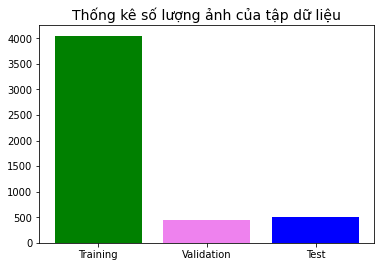

In [ ]:
#Thong ke so luong hinh anh
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return counter

number_data_train = count(train_data_dir)
number_data_val = count(validation_data_dir)
number_data_test = count(test_data_dir)

print("Data Training:",number_data_train)
print("Data Validation:",number_data_val)
print("Data Test Model:", number_data_test)
print("Total Dataset:", number_data_train+number_data_val+number_data_test)
x = ['Training', 'Validation', 'Test']
y = [number_data_train, number_data_val, number_data_test]
Data = {'Dataset': x,
        'Data': y}
df = pd.DataFrame(Data,columns=['Dataset','Data'])

New_Colors = ['green','violet','blue']
plt.bar(df['Dataset'], df['Data'], color=New_Colors, width = 0.8)
plt.title('Thống kê số lượng ảnh của tập dữ liệu', fontsize=14)
plt.show()

In [ ]:
# Tang cuong du lieu, giam Overfitting
datagen = ImageDataGenerator(
  featurewise_center=False, # Dat gia tri dau vao thanh 0 tren tap du lieu
  samplewise_center=False, # Dat gia tri trung binh cua moi mau thanh 0
  featurewise_std_normalization=False, # Chia dau vao cho std cua tap du lieu
  samplewise_std_normalization=False,  # Chia moi dau vao cho std cua no
  zca_whitening=False,  # apply ZCA whitening (tay trang)
  rotation_range=10,  # xoay hinh anh ngau nhien trong pham vi (do, 0 den 180) 
  zoom_range = 0.2, # Hinh anh thu phong ngau nhien
  width_shift_range=0.1,  # Dich chuyen ngau nhien hinh anh theo chieu ngang
  height_shift_range=0.1,  # Dich chuyen ngau nhien hinh anh theo chieu doc
  horizontal_flip=True,  # Dieu chinh hinh anh lat ngang
  vertical_flip=False, # Dieu chinh hinh anh lat ngau nhien 
  brightness_range=[0.2, 1.5] # Dieu chinh do sang cua anh
)

In [ ]:
# Dieu chinh kich thuoc anh, so batch_size
width = 224
height = 224
batch_size = 32

In [ ]:
train_generator = datagen.flow_from_directory(  
  train_data_dir,
  target_size=(width, height),
  batch_size=batch_size,
  class_mode='categorical',
  shuffle=True,
  seed=123
)

validation_generator = datagen.flow_from_directory(  
  validation_data_dir,
  target_size=(width, height),
  batch_size=batch_size,
  class_mode='categorical',
  shuffle=True,
  seed=123
)

Found 4050 images belonging to 5 classes.
Found 450 images belonging to 5 classes.


In [ ]:
class_name = list(train_generator.class_indices)
print(class_name)
print(type(class_name))

['bacterial_blight', 'blast', 'brown_spot', 'healthy', 'neck_blast']
<class 'list'>


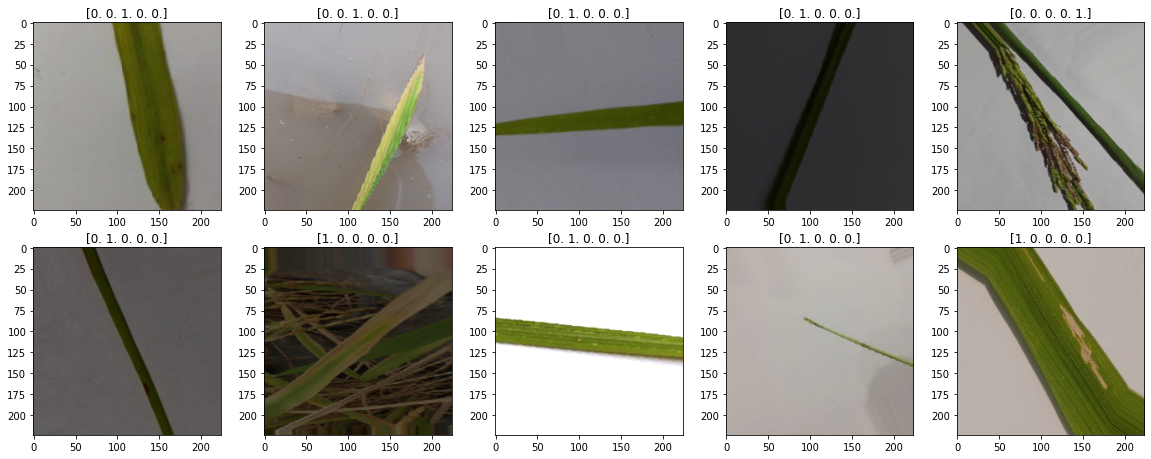

In [ ]:
plt.figure(figsize=(20, 20))

x, y = train_generator.next()
for i in range(10):  
  plt.subplot(5, 5, i+1)
  #In nhãn (class)
  plt.title(([y[i]][0]))
  plt.xticks()
  plt.yticks()
  plt.grid(False)
  #In hình
  plt.imshow(x[i].astype('uint8')) 
plt.show()

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model= ResNet50(
  weights='imagenet',
  input_shape=(width, height, 3),
  include_top=False
)

x = base_model.output

x = GlobalMaxPooling2D()(x)
# Them cac lop FC
x = Dense(1024, activation='relu', name='fc1')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', name='fc2')(x)
x = Dropout(0.5)(x)
outs = Dense(5, activation='softmax', name='predictions')(x)

for layer in base_model.layers:
        layer.trainable=False

model_resnet50 = Model(inputs=base_model.inputs, outputs= outs)

94765736/94765736 [==============================] - 7s 0us/step


In [ ]:
model_resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
#base_model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])


model_resnet50.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
print(len(train_generator))
print(len(validation_generator))

127
15


In [ ]:
epochs = 100
History = model_resnet50.fit_generator(
  generator=train_generator,
  steps_per_epoch=len(train_generator),
  validation_data=validation_generator,
  validation_steps=len(validation_generator),
  epochs=epochs
)

In [ ]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
  test_data_dir,
  target_size=(height, width), 
  batch_size = batch_size,
  class_mode='categorical', 
  shuffle=False
)

Found 500 images belonging to 5 classes.


In [ ]:
loss, accuracy = model_resnet50.evaluate(validation_generator, verbose=2)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

15/15 - 25s - loss: 0.6236 - accuracy: 0.7600 - 25s/epoch - 2s/step
Test accuracy : 0.7599999904632568
Test loss : 0.6235741972923279


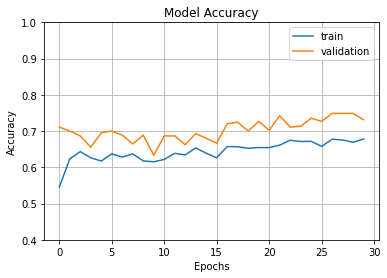

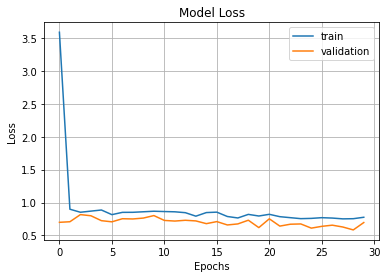

In [ ]:
import matplotlib.pyplot as plt
fig1 = plt.gcf()
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
class_name = list(test_generator.class_indices)
print(class_name)
print(type(class_name))

['bacterial_blight', 'blast', 'brown_spot', 'healthy', 'neck_blast']
<class 'list'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


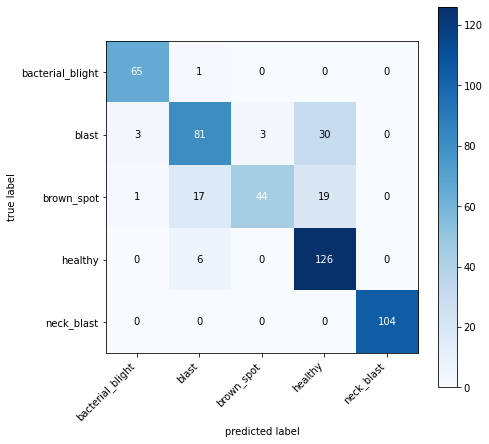

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        66
           1       0.77      0.69      0.73       117
           2       0.94      0.54      0.69        81
           3       0.72      0.95      0.82       132
           4       1.00      1.00      1.00       104

    accuracy                           0.84       500
   macro avg       0.87      0.83      0.84       500
weighted avg       0.85      0.84      0.83       500



In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class_names = class_name

predictions = model.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes
y_target = class_name

matc=confusion_matrix(y_real, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=matc, figsize=(7,7), colorbar=True)

ax.set_xticklabels([''] + list(np.unique(y_target)), rotation=45, fontsize=10, ha='right')
ax.set_yticklabels([''] + list(np.unique(y_target)))
plt.show()
#plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 2))

In [ ]:
model_resnet_50.save("/content/drive/MyDrive/GraduationThesis_CN_DC/Models/TransferLearning_ResNet50_V3.h5")

In [ ]:
from tensorflow.keras.models import load_model
model_resnet_50 = load_model("/content/drive/MyDrive/GraduationThesis_CN_DC/Models/TransferLearning_ResNet50_V3.h5")

In [ ]:
loss, accuracy = model_resnet_50.evaluate(test_generator, verbose=2)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

16/16 - 281s - loss: 0.3692 - accuracy: 0.8660 - 281s/epoch - 18s/step
Test accuracy : 0.8659999966621399
Test loss : 0.36919912695884705


In [ ]:
epochs = 20
History = model_resnet_50.fit_generator(
  generator=train_generator,
  steps_per_epoch=len(train_generator),
  validation_data=validation_generator,
  validation_steps=len(validation_generator),
  epochs=epochs
)

127/127 [==============================] - 218s 2s/step - loss: 0.4198 - accuracy: 0.8296 - val_loss: 0.4322 - val_accuracy: 0.8378
Epoch 12/20
127/127 [==============================] - 217s 2s/step - loss: 0.4233 - accuracy: 0.8291 - val_loss: 0.4749 - val_accuracy: 0.8200
Epoch 13/20
127/127 [==============================] - 216s 2s/step - loss: 0.4449 - accuracy: 0.8244 - val_loss: 0.5110 - val_accuracy: 0.7978
Epoch 14/20
127/127 [==============================] - 215s 2s/step - loss: 0.4198 - accuracy: 0.8368 - val_loss: 0.5205 - val_accuracy: 0.8067
Epoch 15/20
127/127 [==============================] - 216s 2s/step - loss: 0.4155 - accuracy: 0.8306 - val_loss: 0.4382 - val_accuracy: 0.8311
Epoch 16/20
127/127 [==============================] - 215s 2s/step - loss: 0.4326 - accuracy: 0.8225 - val_loss: 0.4443 - val_accuracy: 0.8156
Epoch 17/20
127/127 [==============================] - 214s 2s/step - loss: 0.4088 - accuracy: 0.8368 - val_loss: 0.4855 - val_accuracy: 0.8311
Epoc

In [ ]:
loss, accuracy = model_resnet_50.evaluate(test_generator, verbose=2)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

16/16 - 19s - loss: 0.3676 - accuracy: 0.8680 - 19s/epoch - 1s/step
Test accuracy : 0.8679999709129333
Test loss : 0.36764955520629883


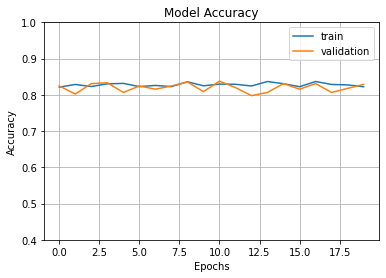

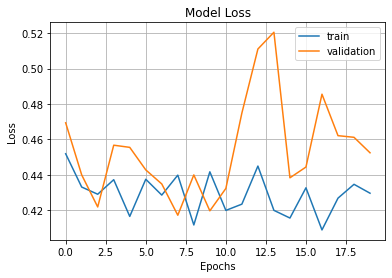

In [ ]:
import matplotlib.pyplot as plt
fig1 = plt.gcf()
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


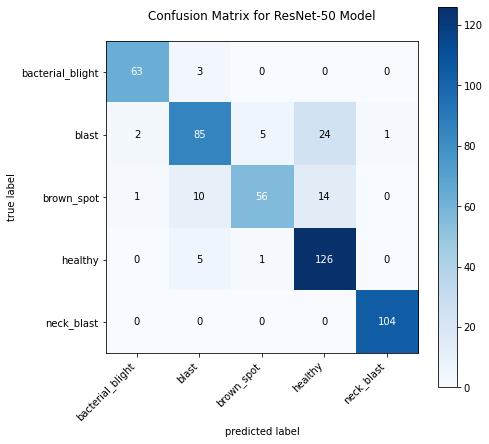

                  precision    recall  f1-score   support

bacterial_blight       0.95      0.95      0.95        66
           blast       0.83      0.73      0.77       117
      brown_spot       0.90      0.69      0.78        81
         healthy       0.77      0.95      0.85       132
      neck_blast       0.99      1.00      1.00       104

        accuracy                           0.87       500
       macro avg       0.89      0.87      0.87       500
    weighted avg       0.87      0.87      0.87       500



In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class_name = list(test_generator.class_indices)
predictions = model_resnet_50.predict_generator(generator=test_generator)

y_pred = np.argmax(predictions, axis=1)
y_real = test_generator.classes
y_target = class_name

matc=confusion_matrix(y_real, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=matc, figsize=(7,7), colorbar=True)

ax.set_title('Confusion Matrix for ResNet-50 Model')

ax.set_xticklabels([''] + list(np.unique(y_target)), rotation=45, fontsize=10, ha='right')
ax.set_yticklabels([''] + list(np.unique(y_target)))
plt.show()

target_names = ['bacterial_blight', 'blast', 'brown_spot', 'healthy', 'neck_blast']

print(metrics.classification_report(y_real,y_pred, digits = 2, target_names=target_names))

(1, 224, 224, 3)
1/1 [==============================] - 0s 23ms/step


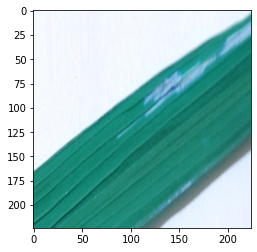

The predicted class is bacterial_blight


In [ ]:
#number = 101
#image_from_test_data = "/content/drive/MyDrive/GraduationThesis_CN_DC/Dataset/Dataset-Processing-Version-02/test/blast/rice_blast_{}".format(number)+".jpg"
image_from_test_data = "/content/drive/MyDrive/GraduationThesis_CN_DC/Dataset/Dataset-Processing/test/bacterial_blight/bacterial_blight_104.jpg"
image=cv2.imread(image_from_test_data)
image_resized= cv2.resize(image, (224, 224))
image=np.expand_dims(image_resized, axis=0)
print(image.shape)

pred=model_resnet_50.predict(image)
pred_digits=np.argmax(pred)

plt.imshow(np.squeeze(image))
plt.show()

output_class=class_name[np.argmax(pred)]
print("The predicted class is", output_class)

In [ ]:
model_resnet_50.save("/content/drive/MyDrive/GraduationThesis_CN_DC/Models/TransferLearning_ResNet50_V4.h5")